In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sbcbinaryformat import Streamer, Writer
import scipy.signal as sg
from pathlib import Path
import pandas as pd
import re
import json
import math

ana_path = "../LAr10Ana/"
sys.path.insert(0, ana_path)
seitz_path = "../SeitzModel/"
sys.path.insert(0, seitz_path)

from GetEvent import GetEvent, GetRun
from REFPROP import SeitzModel as sm

%matplotlib inline

In [80]:
T = np.array([116.7, 119.6])
P = np.array([1.5, 1.75, 2, 2.25, 2.5, 3, 3.5, 4, 4.5, 5])
P_mesh, T_mesh = np.meshgrid(P, T)
P_mesh, T_mesh = np.ravel(P_mesh), np.ravel(T_mesh)
T_mesh_C = T_mesh - 273.15
P_mesh_psi = P_mesh * 14.5

seitz = sm(P_mesh_psi, T_mesh_C, "Argon")
seitz = seitz.__dict__
units = seitz.pop("Units")
del units["Units"]
for k,v in units.items():
    seitz[f"{k} ({v})"] = seitz.pop(k)

df = pd.DataFrame(seitz)
e_vals = df.pivot(index="P (psia)", columns="T (C)", values="E (keV)")
print(f"E\n{e_vals}\n")
q_vals = df.pivot(index="P (psia)", columns="T (C)", values="Q (keV)")
print(f"Q\n{q_vals}\n")

E
T (C)      -156.45   -153.55
P (psia)                    
21.750    0.487232  0.266865
25.375    0.518765  0.280813
29.000    0.553485  0.295899
32.625    0.591837  0.312251
36.250    0.634343  0.330013
43.500    0.734422  0.370462
50.750    0.860307  0.418917
58.000    1.021650  0.477636
65.250    1.233037  0.549726
72.500    1.517336  0.639564

Q
T (C)      -156.45   -153.55
P (psia)                    
21.750    0.894042  0.459775
25.375    0.963195  0.488270
29.000    1.040334  0.519408
32.625    1.126693  0.553516
36.250    1.223748  0.590974
43.500    1.457421  0.677768
50.750    1.760643  0.784268
58.000    2.162565  0.916677
65.250    2.708714  1.083758
72.500    3.473008  1.298190



In [74]:
recon_path = Path("/exp/e961/data/SBC-25-recon/dev-output/")
data_path = Path("/exp/e961/data/SBC-25-daqdata/")

In [43]:
def gen_run_numbers(run_ranges):
    # input is a tuple or a list of tuples, which contains (date, start_run, end_run)
    if isinstance(run_ranges, tuple):
        run_ranges = [run_ranges]

    ret = [
        f"{date}_{run}"
        for date, start, end in run_ranges
        for run in range(start, end + 1)
    ]

    return ret

In [5]:
def get_runs_between(data_path, start_folder, end_folder):
    pattern = re.compile(r'^\d{8}_\d+.*$')
    all_folders = sorted([
        f.stem for f in data_path.iterdir()
        if pattern.match(f.name)
    ])
    
    if start_folder not in all_folders:
        raise ValueError(f"Start folder '{start_folder}' not found")
    if end_folder not in all_folders:
        raise ValueError(f"End folder '{end_folder}' not found")
    
    start_idx = all_folders.index(start_folder)
    end_idx = all_folders.index(end_folder)
    
    if start_idx > end_idx:
        start_idx, end_idx = end_idx, start_idx
    
    return all_folders[start_idx:end_idx + 1]

In [37]:
def get_livetime_by_pset_rounded(runs, data_path="/exp/e961/data/SBC-25-daqdata/", recon_path="/exp/e961/data/SBC-25-recon/dev-output/"):
    pset_livetimes = {}

    for run in runs:
        try:
            exposure = Streamer(os.path.join(recon_path, run, "exposure.sbc")).to_dict()
        except FileNotFoundError:
            # print(f"Run {run} file not available. Skipping...")
            continue
        
        pt2121 = exposure["PT2121_pressure"]
        livetime = exposure["PT2121_livetime"]

        for ev in range(len(pt2121)):
            real_p = pt2121[ev]

            # Round pset 0.25
            if math.isnan(real_p):
                continue
            elif livetime[ev] < 1:
                continue
            elif real_p <=2.5:
                pset_bin = round(real_p * 4) / 4
            else:
                pset_bin = round(real_p * 2) / 2
            
            if pset_bin not in pset_livetimes:
                pset_livetimes[pset_bin] = []
            pset_livetimes[pset_bin].append(livetime[ev])
            # print(f"run {run} ev {ev}:\tpset: {pset_bin},\tlivetime: {livetime[ev]}s")

    # Calculate average and error for each bin
    results = {}
    for pset, lts in sorted(pset_livetimes.items()):
        lts = np.array(lts)
        results[pset] = {
            "n_events":  len(lts),
            "total":     np.sum(lts),
            "mean":      np.mean(lts),
            "std":       np.std(lts),
            "error":     np.std(lts) / np.sqrt(len(lts)),  # standard error
        }
        print(f"pset: {pset:.2f} bar | n={len(lts):4d} | total={np.sum(lts):8.2f}s | mean={np.mean(lts):.3f}s ± {np.std(lts)/np.sqrt(len(lts)):.3f}s")

    print("\n")
    return results

In [180]:
def get_livetime_by_pset(runs, data_path="/exp/e961/data/SBC-25-daqdata/", recon_path="/exp/e961/data/SBC-25-recon/dev-output/"):
    pset_livetimes = {}

    for run in runs:
        try:
            exposure = Streamer(os.path.join(recon_path, run, "exposure.sbc")).to_dict()
            event_info = Streamer(os.path.join(recon_path, run, "event.sbc")).to_dict()
        except (FileNotFoundError, IndexError):
            # print(f"Run {run} file not available. Skipping...")
            continue
        
        pt2121 = exposure["PT2121_pressure"]
        livetime = exposure["PT2121_livetime"]

        for ev in range(len(pt2121)):
            real_p = pt2121[ev]
            try:
                pset_lo = event_info["pset_lo"][ev]
            except KeyError:
                pset_lo = event_info["pset"][ev]
            pset_hi = event_info["pset_hi"][ev]

            # Round pset 0.25
            if math.isnan(real_p):
                continue
            elif pset_lo != pset_hi:
                continue
            elif abs(real_p - pset_lo) > 0.5:
                continue
            else: pset_bin = pset_lo
            
            if pset_bin not in pset_livetimes:
                pset_livetimes[pset_bin] = []
            pset_livetimes[pset_bin].append(livetime[ev])
            # print(f"run {run} ev {ev}:\tpset: {pset_bin},\tlivetime: {livetime[ev]}s")

    # Calculate average and error for each bin
    results = {}
    for pset, lts in sorted(pset_livetimes.items()):
        lts = np.array(lts)
        results[pset] = {
            "n_events":  len(lts),
            "total":     np.sum(lts),
            "mean":      np.mean(lts),
            "std":       np.std(lts),
            "error":     np.std(lts) / np.sqrt(len(lts)),  # standard error
        }
        print(f"pset: {pset:.2f} bar | n={len(lts):4d} | total={np.sum(lts):8.2f}s | mean={np.mean(lts):.3f}s ± {np.std(lts)/np.sqrt(len(lts)):.3f}s")

    print("\n")
    return results

In [181]:
cold_data = get_runs_between(data_path, "20251015_0", "20260125_8")
cold_livetimes = get_livetime_by_pset(cold_data)
warm_data = get_runs_between(data_path, "20260130_0", "20260225_1")
warm_livetimes = get_livetime_by_pset(warm_data)

livetime = {(t, p): 0 for t, p in zip(T_mesh, P_mesh)}
for p in P:
    try:
        livetime[(116.7, p)] = cold_livetimes[p]["total"]/3600
        livetime[(119.6, p)] = warm_livetimes[p]["total"]/3600
    except KeyError:
        continue

pset: 1.50 bar | n= 550 | total=10101.97s | mean=18.367s ± 1.093s
pset: 1.75 bar | n= 844 | total=23660.05s | mean=28.033s ± 1.160s
pset: 2.00 bar | n= 729 | total=21170.49s | mean=29.040s ± 1.320s
pset: 2.25 bar | n=3142 | total=119669.63s | mean=38.087s ± 0.784s
pset: 2.50 bar | n=3206 | total=131059.27s | mean=40.879s ± 0.801s
pset: 2.75 bar | n=  31 | total=  745.32s | mean=24.043s ± 3.170s
pset: 3.00 bar | n=3157 | total=142190.34s | mean=45.040s ± 0.861s
pset: 3.50 bar | n=2545 | total=137533.34s | mean=54.041s ± 1.011s
pset: 4.00 bar | n=2743 | total=180704.87s | mean=65.879s ± 1.118s
pset: 4.50 bar | n=2565 | total=187554.13s | mean=73.121s ± 1.219s
pset: 5.00 bar | n= 504 | total=43990.21s | mean=87.282s ± 3.237s
pset: 6.00 bar | n=  25 | total= 1017.76s | mean=40.710s ± 12.172s
pset: 7.00 bar | n=   4 | total=  412.98s | mean=103.245s ± 33.645s
pset: 7.50 bar | n=   2 | total=   44.77s | mean=22.385s ± 3.475s
pset: 8.00 bar | n=  24 | total= 1705.59s | mean=71.066s ± 16.172s


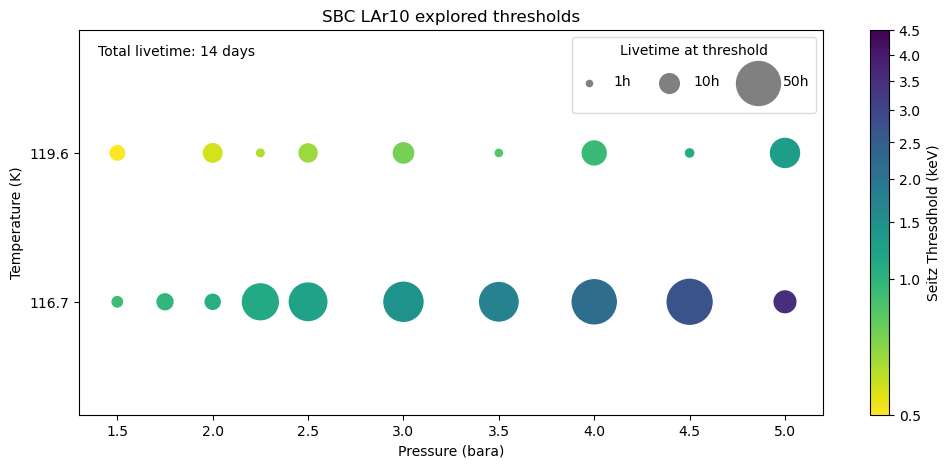

In [182]:
from matplotlib.colors import LogNorm, PowerNorm

plt.figure(figsize=(12,5))
q_flat = df["Q (keV)"].values
e_flat = df["E (keV)"].values
livetime_flat = np.array([livetime[(t, p)] for t, p in zip(T_mesh, P_mesh)])
size_scale=20
scatter = plt.scatter(P_mesh, T_mesh, alpha=1, c=q_flat, cmap='viridis_r', norm=PowerNorm(vmin=0.5, vmax=4.5, gamma=0.5),
                      s=livetime_flat * size_scale)
plt.colorbar(scatter, label='Seitz Thresdhold (keV)')
plt.xlim(1.3, 5.2)
plt.ylim(114.5,122)
plt.yticks([116.7, 119.6])
plt.xlabel("Pressure (bara)")
plt.ylabel("Temperature (K)")
plt.title("SBC LAr10 explored thresholds")

for lt in [1, 10, 50]:
    if lt <= livetime_flat.max():
        plt.scatter([], [], s=lt*size_scale,
                    color='gray', alpha=1, label=f'{lt:d}h\n')
plt.legend(title="Livetime at threshold", loc='upper right', framealpha=0.7,
           labelspacing=1.2, handletextpad=1, borderpad=0.5, ncols=3, handleheight=3, handlelength=1.5)
plt.text(1.4, 121.5, f"Total livetime: {sum(livetime_flat/24).astype("int")} days")
plt.show()

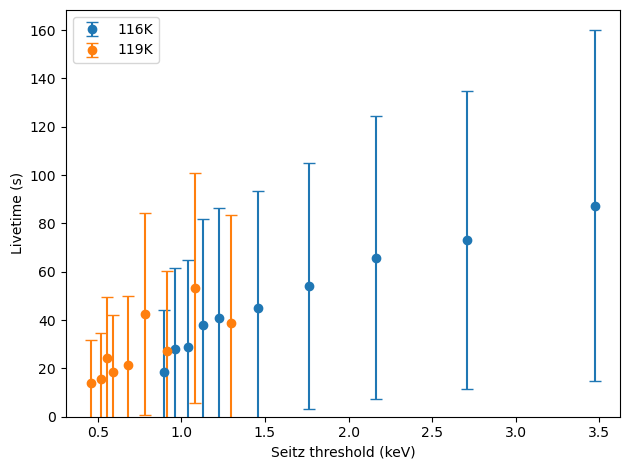

In [183]:
thresholds = q_vals.iloc[:,0]
thresholds_warm = np.delete(q_vals.iloc[:,1], 1)
P_warm = np.delete(P, 1)

fig = plt.figure()
plt.errorbar(thresholds, [cold_livetimes[p]["mean"] for p in P], 
             yerr=[cold_livetimes[p]["std"] for p in P], fmt="o", capsize=4, label="116K")
plt.errorbar(thresholds_warm, [warm_livetimes[p]["mean"] for p in P_warm], 
             yerr=[warm_livetimes[p]["std"] for p in P_warm], fmt="o", capsize=4, label="119K")

plt.ylabel("Livetime (s)")
plt.xlabel("Seitz threshold (keV)")
# plt.yscale("log")
plt.legend()
plt.ylim(0,)
plt.tight_layout()
plt.show()

In [84]:
def plot_livetime_by_pset(results, title=None):
    psets  = sorted(results.keys())
    means  = [results[p]["mean"]    for p in psets]
    stds   = [results[p]["std"]     for p in psets]
    errors = [results[p]["error"]   for p in psets]
    totals = [results[p]["total"]   for p in psets]

    fig = plt.figure()

    plt.errorbar(psets, means, yerr=stds, fmt="o", capsize=4)
    plt.ylabel("Livetime (s)")
    plt.xlabel("Pressure (bar)")
    # plt.yscale("log")
    plt.ylim(0.5,)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [62]:
bg_cold_runs = gen_run_numbers(
    [["20251107", 41, 42],
     ["20251108", 1, 5],
     ["20251112", 18, 19],
     ["20251113", 0, 11],
     ["20251114", 0, 37],
     ["20251115", 0, 5],
     ["20251116", 1, 2],
     ["20251117", 0, 1],
     ["20251118", 8, 9],
     ["20251119", 0, 3],
     ["20251125", 6, 8],
     ["20251126", 7, 8],
     ["20251127", 0, 5],
     ["20251128", 0, 4],
     ["20251129", 0, 5],
     ["20251130", 0, 5],
     ["20251205", 0, 2],
     ["20251206", 0, 5],
     ["20251207", 0, 5],
     ["20251208", 0, 2],
     ["20251211", 5, 7],
     ["20251218", 6, 6],
     ["20251219", 0, 3],
     ["20260106", 3, 3],
     ["20260112", 3, 5],
     ["20260113", 0, 5],
     ["20260115", 5, 5],
     ["20260116", 0, 0],
     ["20260117", 0, 4],
     ["20260118", 0, 4],
     ["20260119", 0, 2],
     ["20260120", 0, 1],
    ])
bg_cold_livetime = get_livetime_by_pset_rounded(bg_cold_runs)

bg_warm_runs = gen_run_numbers(
    [["20260130", 2, 8],
     ["20260131", 0, 10],
     ["20260201", 0, 15],
     ["20260202", 0, 4],
     ["20260204", 0, 7],
     ["20260205", 0, 4],
     ["20260206", 19, 25],
     ["20260207", 0, 5],
     ["20260208", 0, 10],
     ["20260209", 0, 13],
     ["20260210", 0, 7],
     ["20260212", 0, 0],
     ["20260217", 7, 13],
     ["20260218", 0, 16],
     ["20260219", 0, 11],
     ["20260220", 1, 4],
    ])
bg_warm_livetime = get_livetime_by_pset_rounded(bg_warm_runs)

pset: 1.50 bar | n=  69 | total= 3088.23s | mean=44.757s ± 5.621s
pset: 1.75 bar | n= 280 | total=13326.64s | mean=47.595s ± 2.414s
pset: 2.00 bar | n= 208 | total=10982.30s | mean=52.800s ± 3.182s
pset: 2.25 bar | n=1268 | total=71675.69s | mean=56.527s ± 1.394s
pset: 2.50 bar | n=1421 | total=83190.32s | mean=58.544s ± 1.335s
pset: 3.00 bar | n=1500 | total=94559.40s | mean=63.040s ± 1.403s
pset: 3.50 bar | n=1191 | total=79872.12s | mean=67.063s ± 1.598s
pset: 4.00 bar | n=1375 | total=104511.60s | mean=76.008s ± 1.648s
pset: 4.50 bar | n=1182 | total=98759.09s | mean=83.553s ± 1.833s
pset: 5.00 bar | n= 315 | total=29055.47s | mean=92.240s ± 4.097s
pset: 5.50 bar | n=   6 | total=   12.06s | mean=2.010s ± 0.193s
pset: 6.00 bar | n=   2 | total=    6.73s | mean=3.365s ± 0.612s
pset: 6.50 bar | n=   1 | total=    1.27s | mean=1.270s ± 0.000s
pset: 7.00 bar | n=   2 | total=    2.30s | mean=1.150s ± 0.021s
pset: 7.50 bar | n=   1 | total=    4.02s | mean=4.020s ± 0.000s


pset: 1.50 b

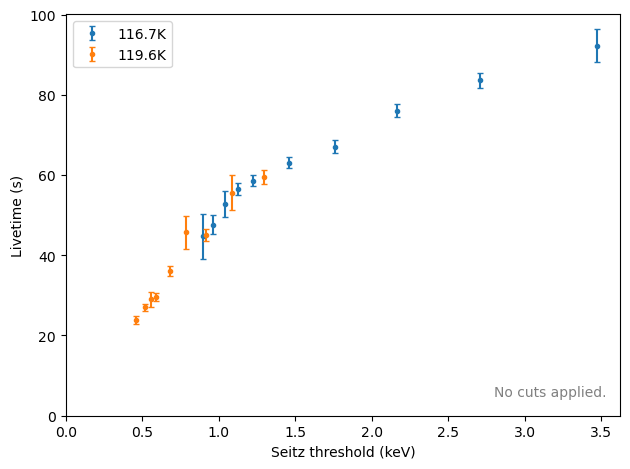

In [184]:
thresholds = q_vals.iloc[:,0]
thresholds_warm = np.delete(q_vals.iloc[:,1], 1)
P_warm = np.delete(P, 1)

fig, ax = plt.subplots(dpi=100)
ax.errorbar(thresholds, [bg_cold_livetime[p]["mean"] for p in P], 
             yerr=[bg_cold_livetime[p]["error"] for p in P], fmt=".", capsize=2, label=f"{T[0]}K")
ax.errorbar(thresholds_warm, [bg_warm_livetime[p]["mean"] for p in P_warm], 
             yerr=[bg_warm_livetime[p]["error"] for p in P_warm], fmt=".", capsize=2, label=f"{T[1]}K")

plt.ylabel("Livetime (s)")
plt.xlabel("Seitz threshold (keV)")
# plt.yscale("log")
plt.legend()
plt.xlim(0,)
plt.ylim(0,)
plt.text(2.8, 5, "No cuts applied.", c="Grey")
plt.tight_layout()
plt.show()

In [79]:
sm(1.5*14.5, 11-273.15, "Argon")

	                   P : 21.75000        psia
	                   T : -156.45000      C
	                   Q : 0.89404         keV
	                   E : 0.48723         keV
	                  Rc : 14.01246        nm
	                  Rl : 4.80315         nm
	                Pvap : 145.90210       psia
	                Pbub : 140.80422       psia
	              DeltaH : 132111.42501    J/kg
	              DeltaS : 1132.06020      J/kg-K
	               Gibbs : -283077.91953   J/kg
	               Rho_l : 1.18397         g/cc
	               Rho_b : 0.04768         g/cc
	               Sigma : 0.00575         N/m
	            dSigmadT : -0.00021        N/m-K
	               P_err : -0.00000        psia
	           Rho_b_err : 0.00000         g/cc
	               G_err : 0.00017         J/kg
	           Sigma_err : 0.00000         N/m
	        dSigmadT_err : 0.00000         N/m-K
	               errID : None           
	   interp_iterations : 36.00000        count
	                  Lt

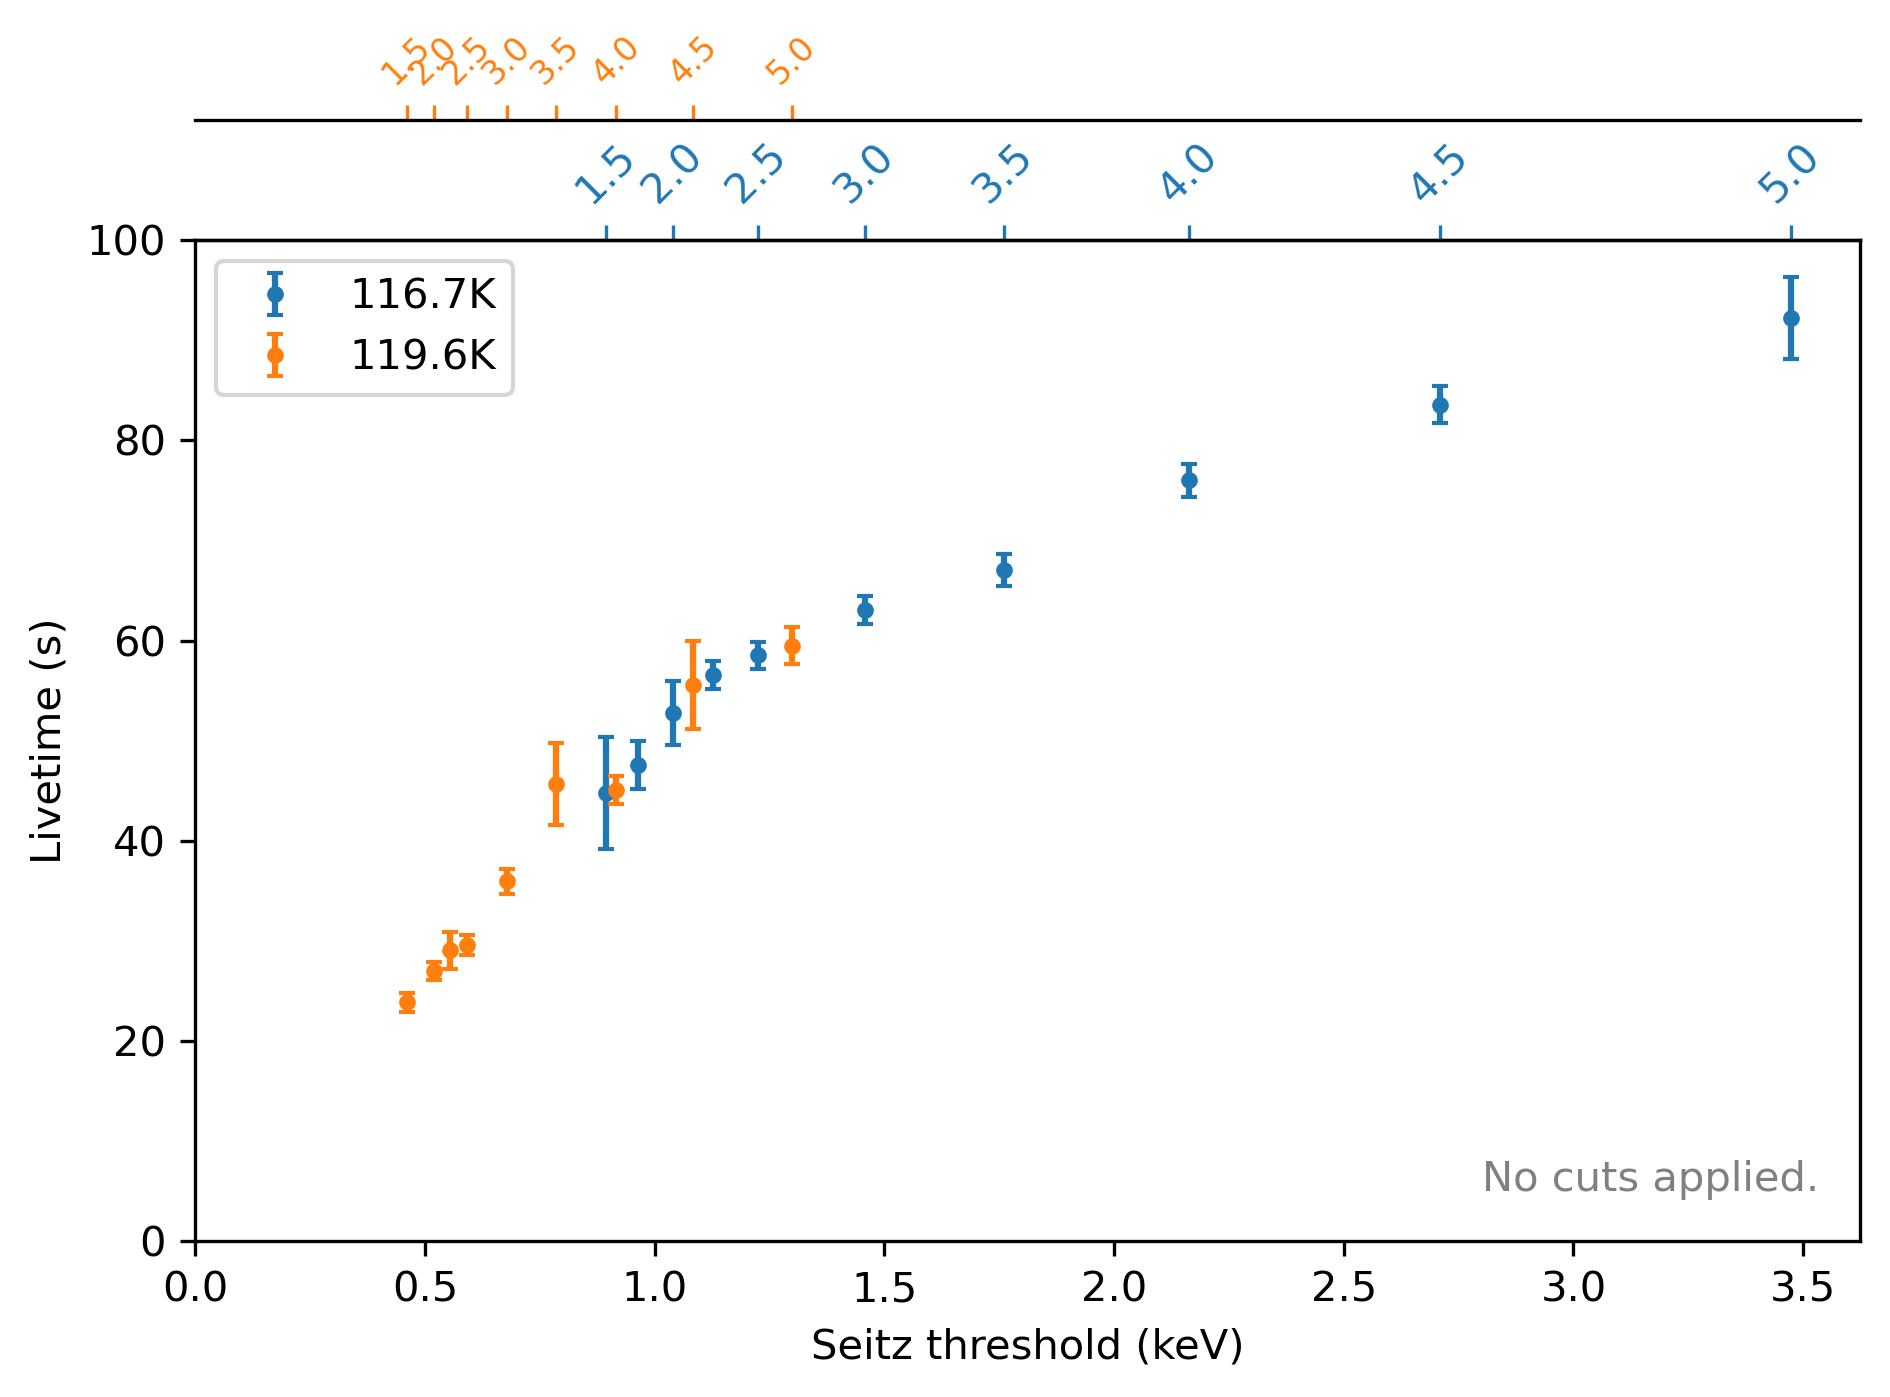

In [132]:
fig, ax = plt.subplots(dpi=300)

ax.errorbar(thresholds, [bg_cold_livetime[p]["mean"] for p in P], 
             yerr=[bg_cold_livetime[p]["error"] for p in P], fmt=".", capsize=2, label=f"{T[0]}K")
ax.errorbar(thresholds_warm, [bg_warm_livetime[p]["mean"] for p in P_warm], 
             yerr=[bg_warm_livetime[p]["error"] for p in P_warm], fmt=".", capsize=2, label=f"{T[1]}K")

ax.set_ylabel("Livetime (s)")
ax.set_xlabel("Seitz threshold (keV)")
ax.set_xlim(0,)
ax.set_ylim(0,)
ax.legend()
ax.text(2.8, 5, "No cuts applied.", c="Grey")

# --- Build interpolators: keV -> Pressure (bar) for each temperature ---
from scipy.interpolate import interp1d

# Cold: thresholds vs P (both full arrays)
cold_keV_to_P = interp1d(thresholds, P, bounds_error=False, fill_value="extrapolate")
cold_P_to_keV = interp1d(P, thresholds, bounds_error=False, fill_value="extrapolate")

# Warm: thresholds_warm vs P_warm
warm_keV_to_P = interp1d(thresholds_warm, P_warm, bounds_error=False, fill_value="extrapolate")
warm_P_to_keV = interp1d(P_warm, thresholds_warm, bounds_error=False, fill_value="extrapolate")

# --- Secondary axis for cold temperature (closer to plot) ---
ax_cold = ax.secondary_xaxis(
    'top',
    functions=(cold_keV_to_P, cold_P_to_keV)
)
P_ticks = P[np.isin(P % 1, [0.0, 0.5])]
ax_cold.tick_params(colors="C0", rotation=45)
ax_cold.set_xticks(P_ticks)  # show ticks at exact pressure values

# --- Secondary axis for warm temperature (further from plot) ---
ax_warm = ax.secondary_xaxis(
    1.12,  # offset above 'top' — adjust as needed
    functions=(warm_keV_to_P, warm_P_to_keV)
)
ax_warm.tick_params(colors="C1", rotation=45, labelsize=8)
ax_warm.set_xticks(P_ticks)

plt.tight_layout()
plt.show()